# Verification of PMCTRACK against ACCACIA and STARS cyclone datasets

In [1]:
from datetime import datetime
from IPython.display import clear_output
import json
import matplotlib.pyplot as plt
# from matplotlib.offsetbox import AnchoredText
from matplotlib.ticker import FuncFormatter
from mpl_toolkits.axes_grid1 import make_axes_locatable
# import matplotlib.cm as mcm
import numpy as np
import pandas as pd
import xarray as xr
import string
from tqdm import tqdm_notebook as tqdm

from arke.cart import lcc_map

from common_defs import winters, nyr, winter_dates, datasets, cat_kw, aliases, conf_key_typeset, runs_grid_formatter
from plot_utils import LCC_KW, trans, clev101, abs_plt_kw, iletters, cc
import mypaths
from stars_api import read_tracks_file

from octant.core import TrackRun, OctantTrack, HOUR
from octant.misc import SUBSETS
import octant
octant.__version__

'0.0.11'

In [2]:
plt.style.use('paperfig.mplstyle')

In [3]:
lsm = xr.open_dataarray(mypaths.era5_dir / 'lsm.nc').squeeze()
lon2d, lat2d = np.meshgrid(lsm.longitude, lsm.latitude)

In [4]:
subsets = SUBSETS[1:]  # only PMC and IC

### All PMCTRACK runs, split into two groups

In [5]:
datasets

['era5', 'interim']

In [6]:
RUNS = dict()
RUNS['vort_thresh'] = dict()
RUNS['diff_params'] = dict()
for dataset in datasets:
    _runs = []
    for run_id_start in [0, 100]:
        with (mypaths.trackresdir / f'{dataset}_{run_id_start:03d}_runs_grid.json').open('r') as f:
            for run_id, run_dict in enumerate(json.load(f), run_id_start):
                _runs.append( (run_id, run_dict) )

    RUNS['vort_thresh'][dataset] = []
    RUNS['diff_params'][dataset] = []
    for run_id, run_dict in _runs:
        if  len(run_dict) == 0 and run_id < 100:
            RUNS['diff_params'][dataset].append( (run_id, run_dict) )
        if 'zeta_max0' in run_dict or len(run_dict) == 0:
            if  run_id >= 100:
                if run_dict != {'zeta_max0': 0.0001, 'zeta_min0': 9e-05}:
                    RUNS['vort_thresh'][dataset].append( (run_id, run_dict) )
        else:
            RUNS['diff_params'][dataset].append( (run_id, run_dict) )

## Verification against ACCACIA

### Load ACCACIA PMC tracks

In [7]:
accacia_pmcs = pd.read_csv(mypaths.acctracks, delimiter='\t', names=['N', 'time', 'lon', 'lat'],
                           parse_dates=['time'], date_parser=lambda x: datetime.strptime(x, '%Y%m%d%H%M'))

In [8]:
acc_tracks = []
for i, df in accacia_pmcs.groupby('N'):
    ot = OctantTrack.from_df(df)
    if ot.lifetime_h >= 6:
        acc_tracks.append(ot)
n_ref = len(acc_tracks)
n_ref

27

In [9]:
acc_tracks[0]

,N,time,lon,lat
0,1,2013-03-20 11:42:00,9.093,76.719
1,1,2013-03-20 12:44:00,8.506,76.525
2,1,2013-03-20 13:23:00,7.698,76.400
3,1,2013-03-20 19:15:00,8.425,76.831


## Load PMCTRACK data for the ACCACIA period

In [10]:
period = 'ACCACIA'
winter = 'accacia'

In [12]:
TRACKS = dict()
for run_group, dataset_dicts in tqdm(RUNS.items(), desc='run_group', leave=False):
    TRACKS[run_group] = dict()
    for dataset, run_dicts in tqdm(dataset_dicts.items(), desc='dataset', leave=False):
        TRACKS[run_group][dataset] = []
        for run_id, run_dict in tqdm(run_dicts, desc='run_id', leave=False):
            track_res_dir = mypaths.trackresdir / dataset / f'run{run_id:03d}' / winter
            TR = TrackRun(track_res_dir)
            TR.categorise(lsm=lsm, **cat_kw)
            TRACKS[run_group][dataset].append(TR)
clear_output()

### Distance matrix viz

In [13]:
method = 'bs2000'
run_group = 'diff_params'
dataset = 'era5'
subset = SUBSETS[1]

In [14]:
match_pairs, dm = TRACKS[run_group][dataset][0].match_tracks(acc_tracks, subset=subset, method=method, beta=50., return_dist_matrix=True)

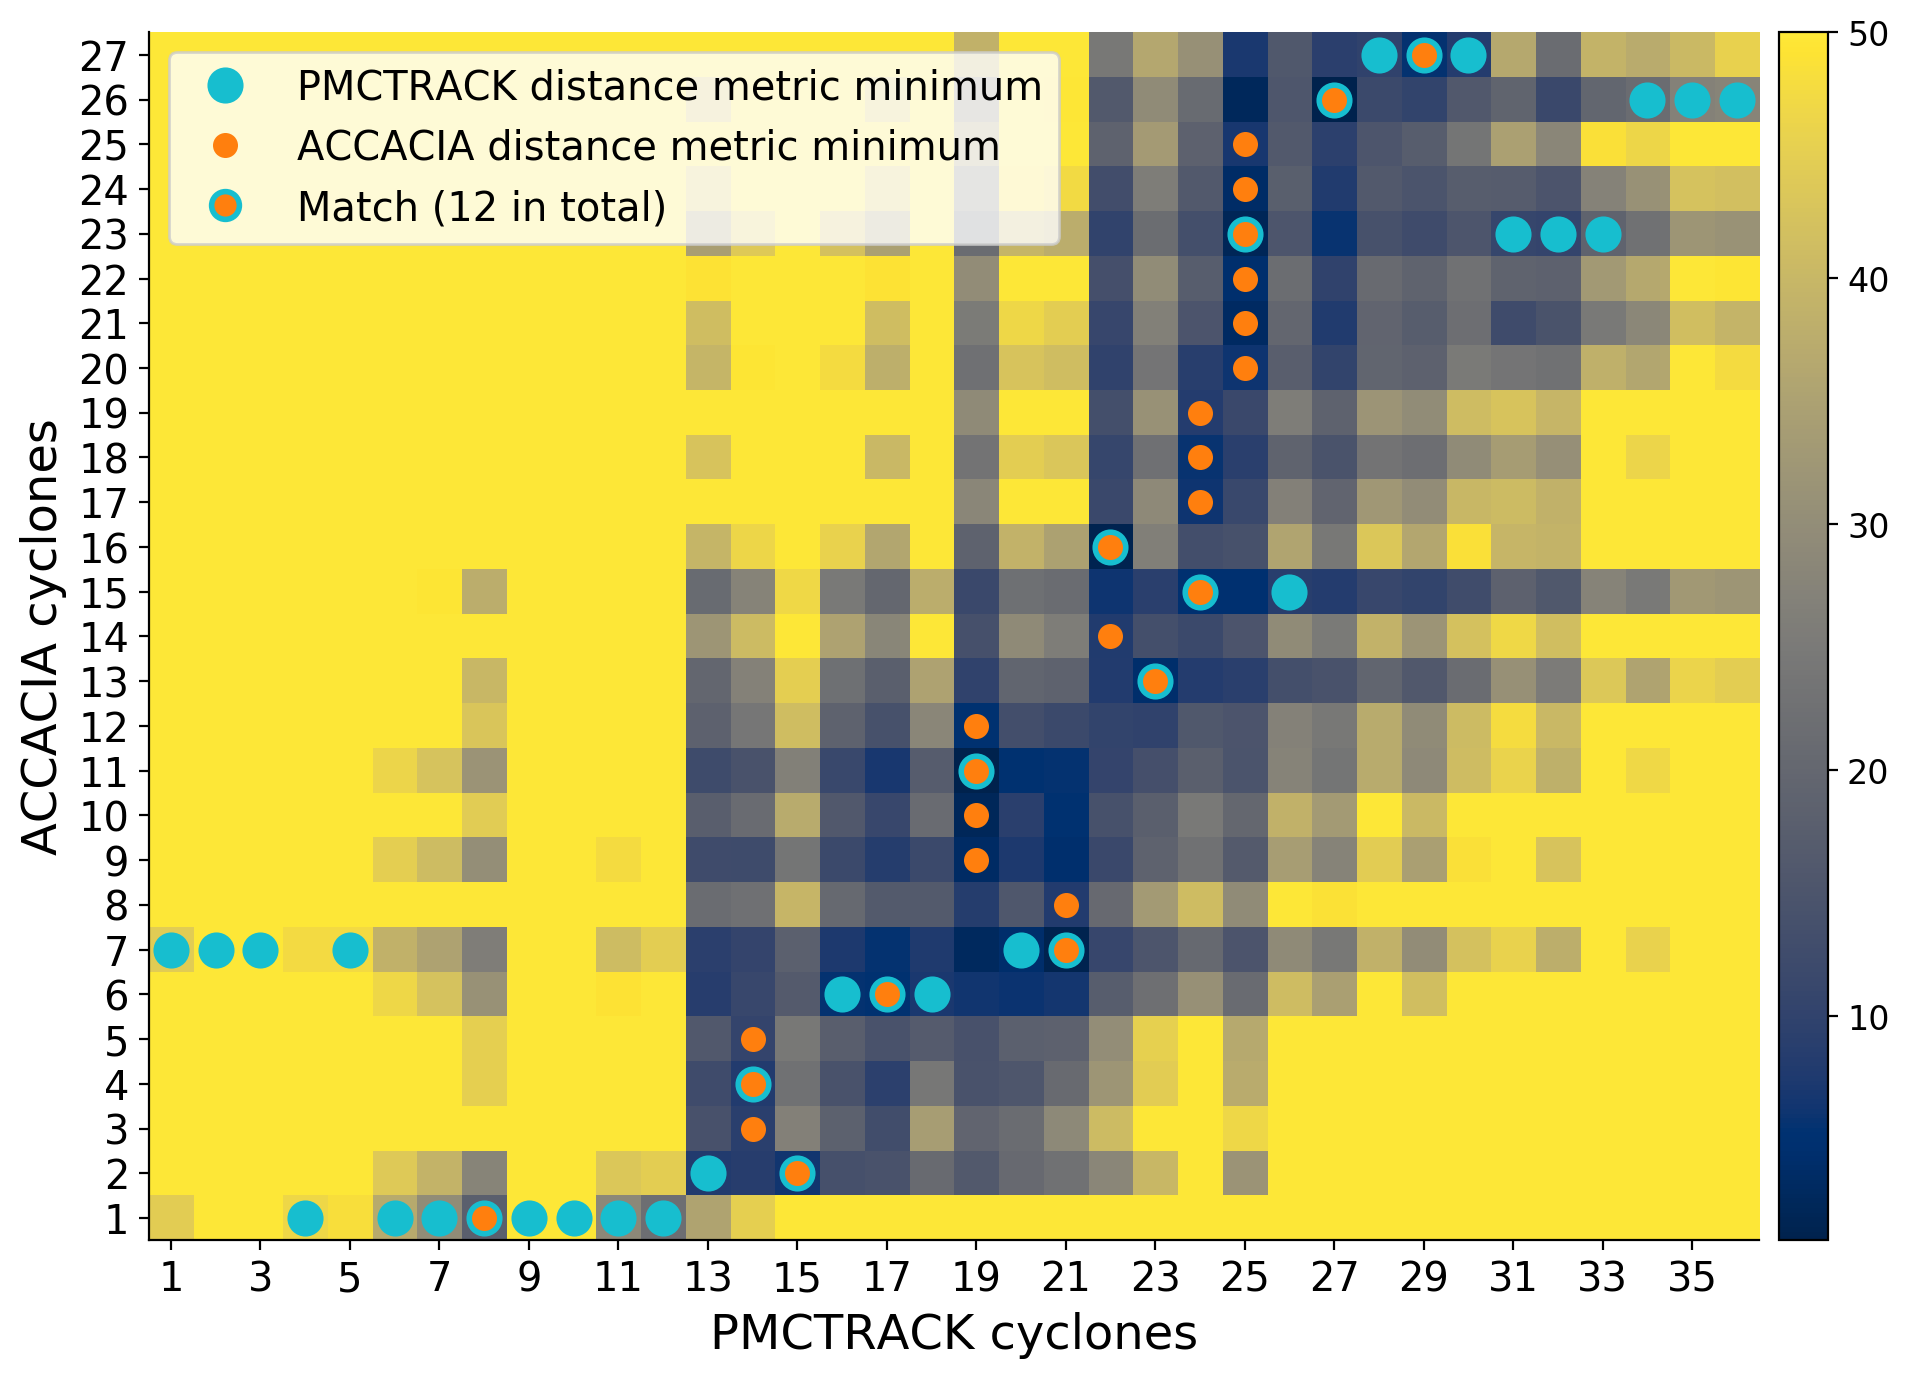

In [15]:
fig, ax = plt.subplots(figsize=(12, 8))
# Plot distance matrix
h = ax.imshow(dm.T, origin='bottom', vmax=50, cmap='cividis')
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='3%', pad=0.1)
fig.colorbar(h, cax=cax)
ax.set_xticks(range(0, dm.shape[0], 2))
ax.set_xticklabels(range(1, dm.shape[0]+1, 2))
ax.set_yticks(range(dm.shape[1]))
ax.set_yticklabels(range(1, dm.shape[1]+1))
ax.tick_params(labelsize='large')

# Overlay with match pair indices
ax.plot(range(dm.shape[0]), dm.argmin(axis=1), marker='o', color='C9', ms=12, linestyle='', label='PMCTRACK distance metric minimum')
ax.plot(dm.argmin(axis=0), range(dm.shape[1]), marker='o', color='C1', ms=8, linestyle='', label='ACCACIA distance metric minimum')
ax.plot([], [], ms=10, marker='o', linestyle='', mec='C9', mew=2, mfc='C1', label=f'Match ({len(match_pairs)} in total)')

# Label the plot
ax.set_xlabel('PMCTRACK cyclones', fontsize='x-large')
ax.set_ylabel('ACCACIA cyclones', fontsize='x-large')
ax.legend(loc=2, fontsize='large')

# Save to file
# fig.savefig(mypaths.plotdir / f'bs2000_distance_metric_matrix_{period}_{dataset}_run{run_id:03d}'.lower())

### Find matches for all runs from both datasets

In [16]:
method = 'bs2000'

In [31]:
MATCH_RATES = dict()
MATCH_PAIRS = dict()
for run_group, dataset_dicts in tqdm(RUNS.items(), desc='run_group', leave=False):
    results = dict()
    MATCH_PAIRS[run_group] = dict()
    for dataset, run_dicts in tqdm(dataset_dicts.items(), desc='dataset', leave=False):
        MATCH_PAIRS[run_group][dataset] = dict()
        perf_table = np.zeros((len(run_dicts), len(subsets)), dtype=np.int64)
        for irun, (run_id, run_dict) in tqdm(enumerate(run_dicts), desc='run_id', leave=False):
            for isub, subset in tqdm(enumerate(subsets), desc='subsets', leave=False):
                match_pairs = TRACKS[run_group][dataset][irun].match_tracks(acc_tracks,
                                                                            method=method, beta=50.,
                                                                            subset=subset)
                if len(run_dict) == 0:
                    # save id of matched vortices in the ctrl run ( {} )
                    MATCH_PAIRS[run_group][dataset][subset] = match_pairs
                perf_table[irun, isub] = len(match_pairs)
        if run_group == 'vort_thresh':
            index = [r[1].get('zeta_max0', 2e-4) for r in run_dicts]
        else:
            index = range(len(run_dicts))
        results[dataset] = pd.DataFrame(data=perf_table,
                                        columns=subsets,
                                        index=index)
    res_df = pd.merge(*results.values(), how='outer', left_index=True, right_index=True, suffixes=['_'+i for i in datasets])
    res_df[res_df==0] = np.nan
    MATCH_RATES[run_group] = ((res_df / n_ref)
                              .reset_index(level=0)
                              .rename(columns=dict(index=run_group)))
clear_output()

## Vorticity thresholds

In [71]:
run_group = 'vort_thresh'

In [72]:
lcc_kw_zoom = LCC_KW.copy()
lcc_kw_zoom.update(extent=[-10, 35, 65, 81],
                   ticks=[5, 1])

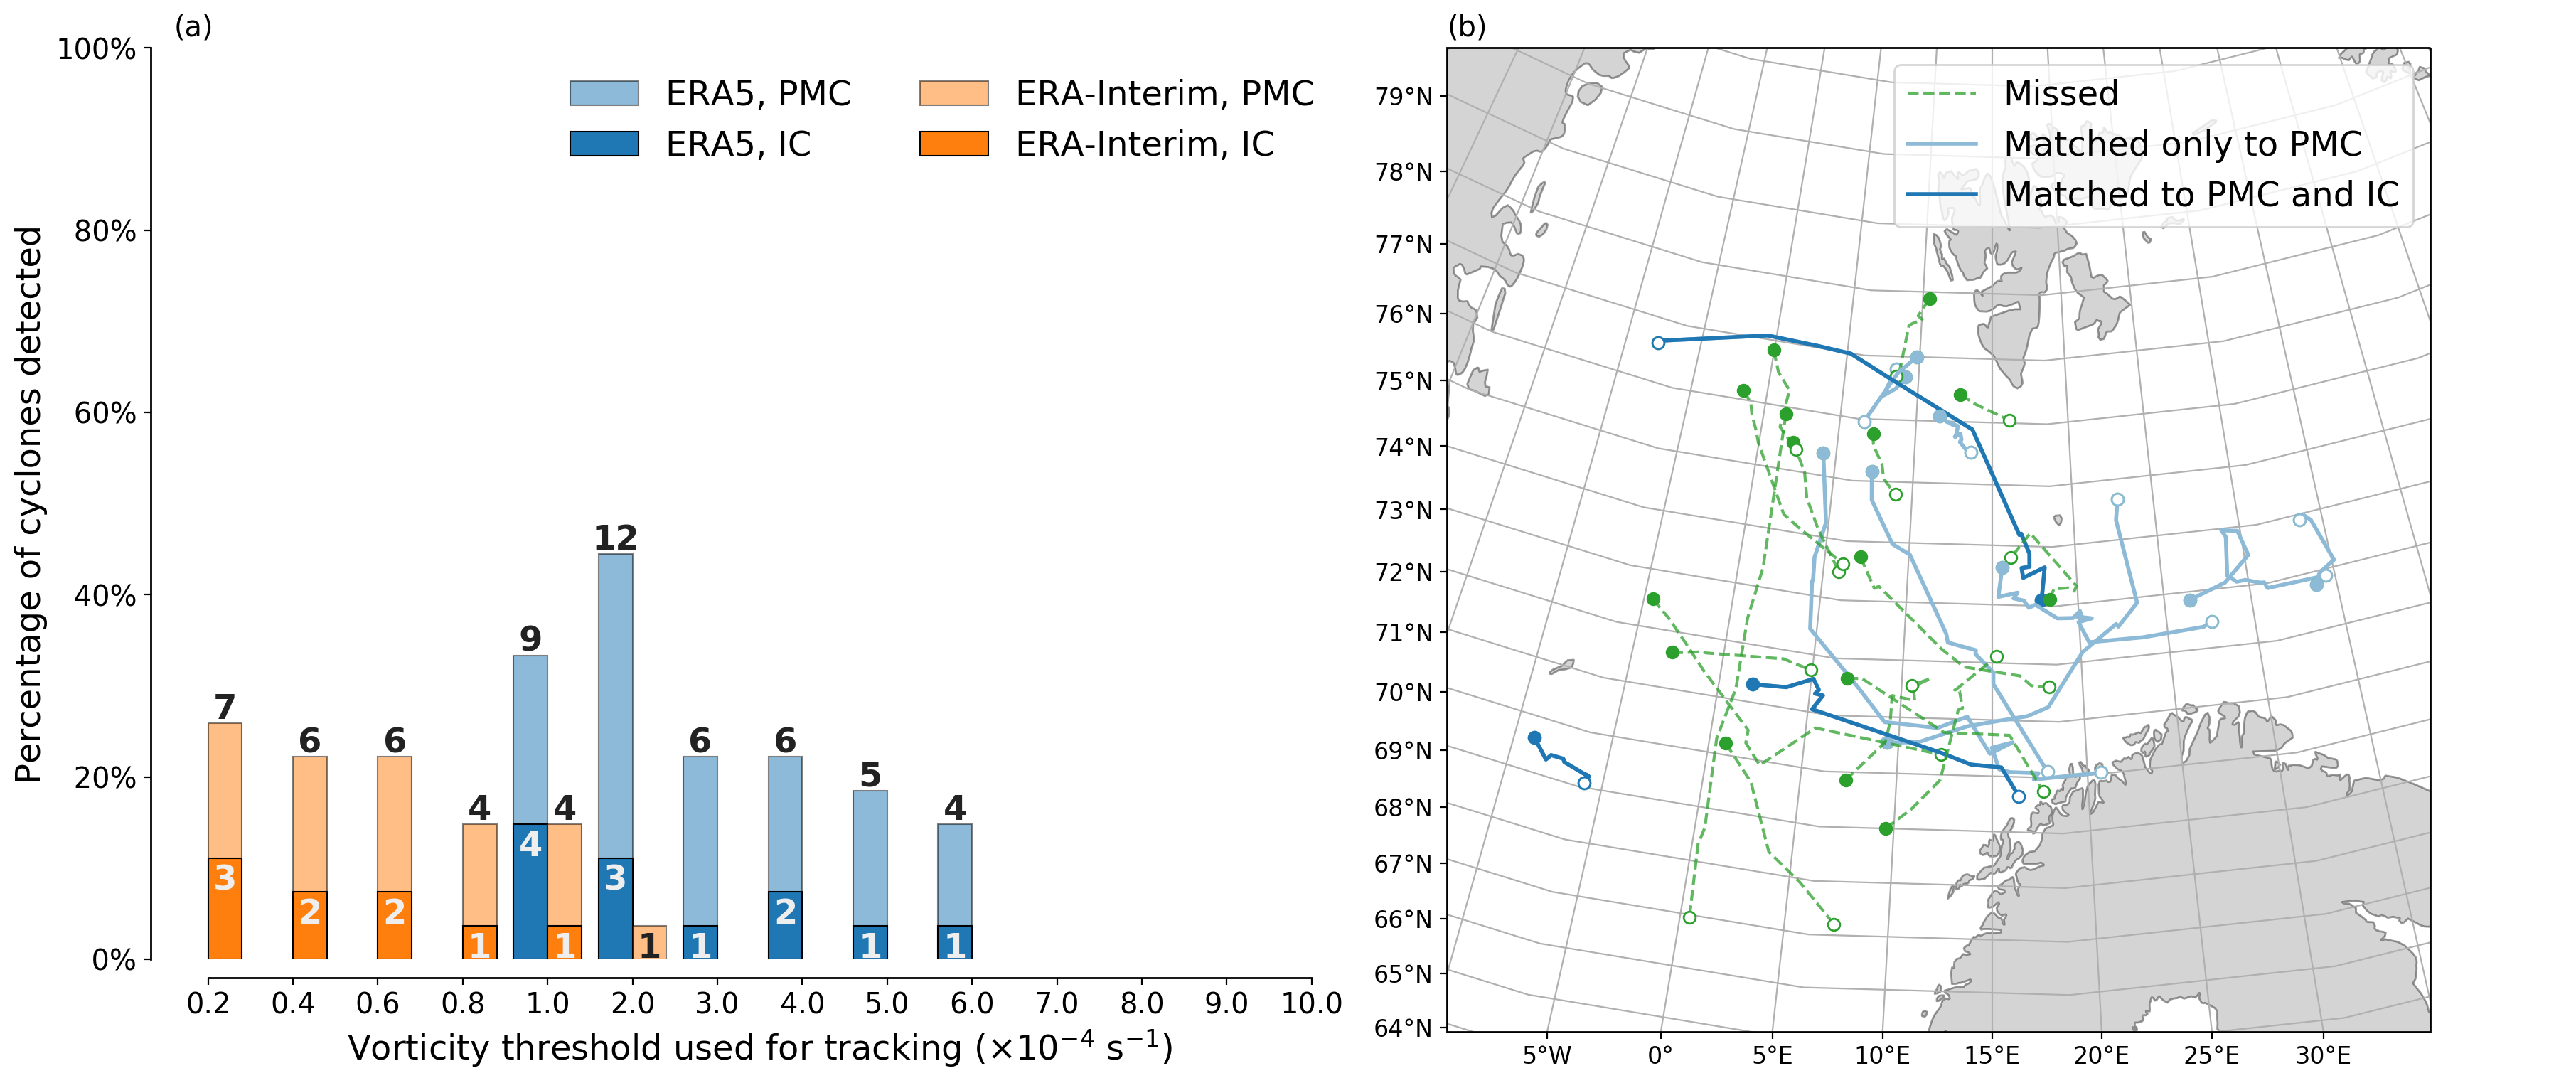

In [73]:
fig = plt.figure(figsize=(18, 7.5), constrained_layout=True)

width = 0.4

ax = fig.add_subplot(121)
for j, (dataset, color) in enumerate(zip(datasets, cc)):
    for i, (subset) in enumerate(subsets):
        res_df = MATCH_RATES[run_group]
        ax.bar(res_df.index.values + j*width, res_df[f'{subset}_{dataset}'],
               width=width,
               **color,
               alpha= 0.5 * (i+1),
               edgecolor='#000000',
               linewidth=0.75,
               label=f'{aliases[dataset]}, {aliases[subset]}')
        
ax.legend(loc=1, ncol=2, fontsize='x-large', frameon=False)

for spine in ax.spines.values():
    if spine.spine_type in ['top', 'right']:
        spine.set_linewidth(0)
    else:
        spine.set_linewidth(1)
        spine.set_position(('axes', -0.02))
        spine.set_position(('axes', -0.02))


ax.set_xticks(res_df.index.values + width/2)
ax.set_xticklabels((1e4 * res_df[run_group].values).round(decimals=1))
ax.set_xlim(ax.get_xticks()[0]-width, ax.get_xticks()[-1]+width)
ax.set_ylim(0, 1)

ax.spines['bottom'].set_bounds(ax.get_xticks()[0], ax.get_xticks()[-1])

percent_formatter = FuncFormatter(lambda x, position: f'{x*100:3.0f}%')
ax.yaxis.set_major_formatter(percent_formatter)

ax.tick_params(labelsize='large')

# Annotate bars
fontcolor = '#222222'
for i, p in enumerate(sorted(ax.patches, key=lambda x: x.get_x())):
    if p.get_height() > 0:
        try:
            if np.allclose(p.get_x(), _p.get_x()):
                fontcolor = '#EEEEEE'
                # if abs(p.get_height() - _p.get_height()) < 0.03:
                an.set_y(_p.get_height() + 0.005)
            else:
                fontcolor = '#222222'
        except NameError:
            pass
        
        an = ax.annotate('{:d}'.format(int(p.get_height() * n_ref)),
                         (p.get_x()+0.2, p.get_height()-0.035),
                         ha='center', fontweight='bold', color=fontcolor,
                         size='x-large')
        _p = p
ax.set_xlabel(r'Vorticity threshold used for tracking ($\times10^{-4}$ $s^{-1}}$)', fontsize='x-large')
ax.set_ylabel('Percentage of cyclones detected', fontsize='x-large')
# ttl = ax.set_title(f'Number of matched vortices\nPMCTRACK vs {period}', loc='left', fontsize='xx-large');
# ax.add_artist(AnchoredText('a', loc=2, prop=dict(size='large')));
ax.set_title('(a)', loc='left', fontsize='large')

#
# Show on the map what tracks are matched in CTRL runs
#
ax = lcc_map(fig, 122, **lcc_kw_zoom)

run_group = 'vort_thresh'
dataset = 'era5'

labels = ['Missed',
          f'Matched only to {aliases[subsets[0]]}',
          f'Matched only to {aliases[subsets[1]]}',
          f'Matched to {aliases[subsets[0]]} and {aliases[subsets[1]]}']
hs = [None] * 4
for idx, acc_df in enumerate(acc_tracks):
    acc_df.plot_track(ax=ax, color='C2', linestyle='--', alpha=0.75, **trans)
    hs[0], = ax.plot(acc_df.lon[0], acc_df.lat[0], color='C2', linestyle='--', alpha=0.75, **trans)
    if idx in [i[1] for i in MATCH_PAIRS[run_group][dataset][subsets[0]]]:
        acc_df.plot_track(ax=ax, color='#8DBAD7', linewidth=2, **trans)
        hs[1], = ax.plot(acc_df.lon[0], acc_df.lat[0], color='#8DBAD7', linewidth=2, **trans)
    if all([idx in [i[1] for i in MATCH_PAIRS[run_group][dataset][subset]] for subset in subsets]):
        acc_df.plot_track(ax=ax, color='C0', linewidth=2, **trans)
        hs[3], = ax.plot(acc_df.lon[0], acc_df.lat[0], color='C0', linewidth=2, **trans)
    elif idx in [i[1] for i in MATCH_PAIRS[run_group][dataset][subsets[1]]]:
        acc_df.plot_track(ax=ax, color='#00035b', linewidth=2, **trans)
        hs[2], = ax.plot(acc_df.lon[0], acc_df.lat[0], color='#00035b', linewidth=2, **trans)
        
hs, labels = [h for h, lab in zip(hs, labels) if h], [lab for h, lab in zip(hs, labels) if h]
    
ax.legend(hs, labels, loc=1, fontsize='x-large')
# ax.add_artist(AnchoredText('b', loc=2, prop=dict(size='large')));
ax.set_title('(b)', loc='left', fontsize='large')

fig.savefig(mypaths.plotdir / f'vs_{period.lower()}_vort_thresh_w_map_{method}')

## Other parameters

In [52]:
run_group = 'diff_params'

In [53]:
xlabels = [runs_grid_formatter(run_dict).strip()
           for i, (run_id, run_dict) in enumerate(RUNS[run_group]['era5'])]

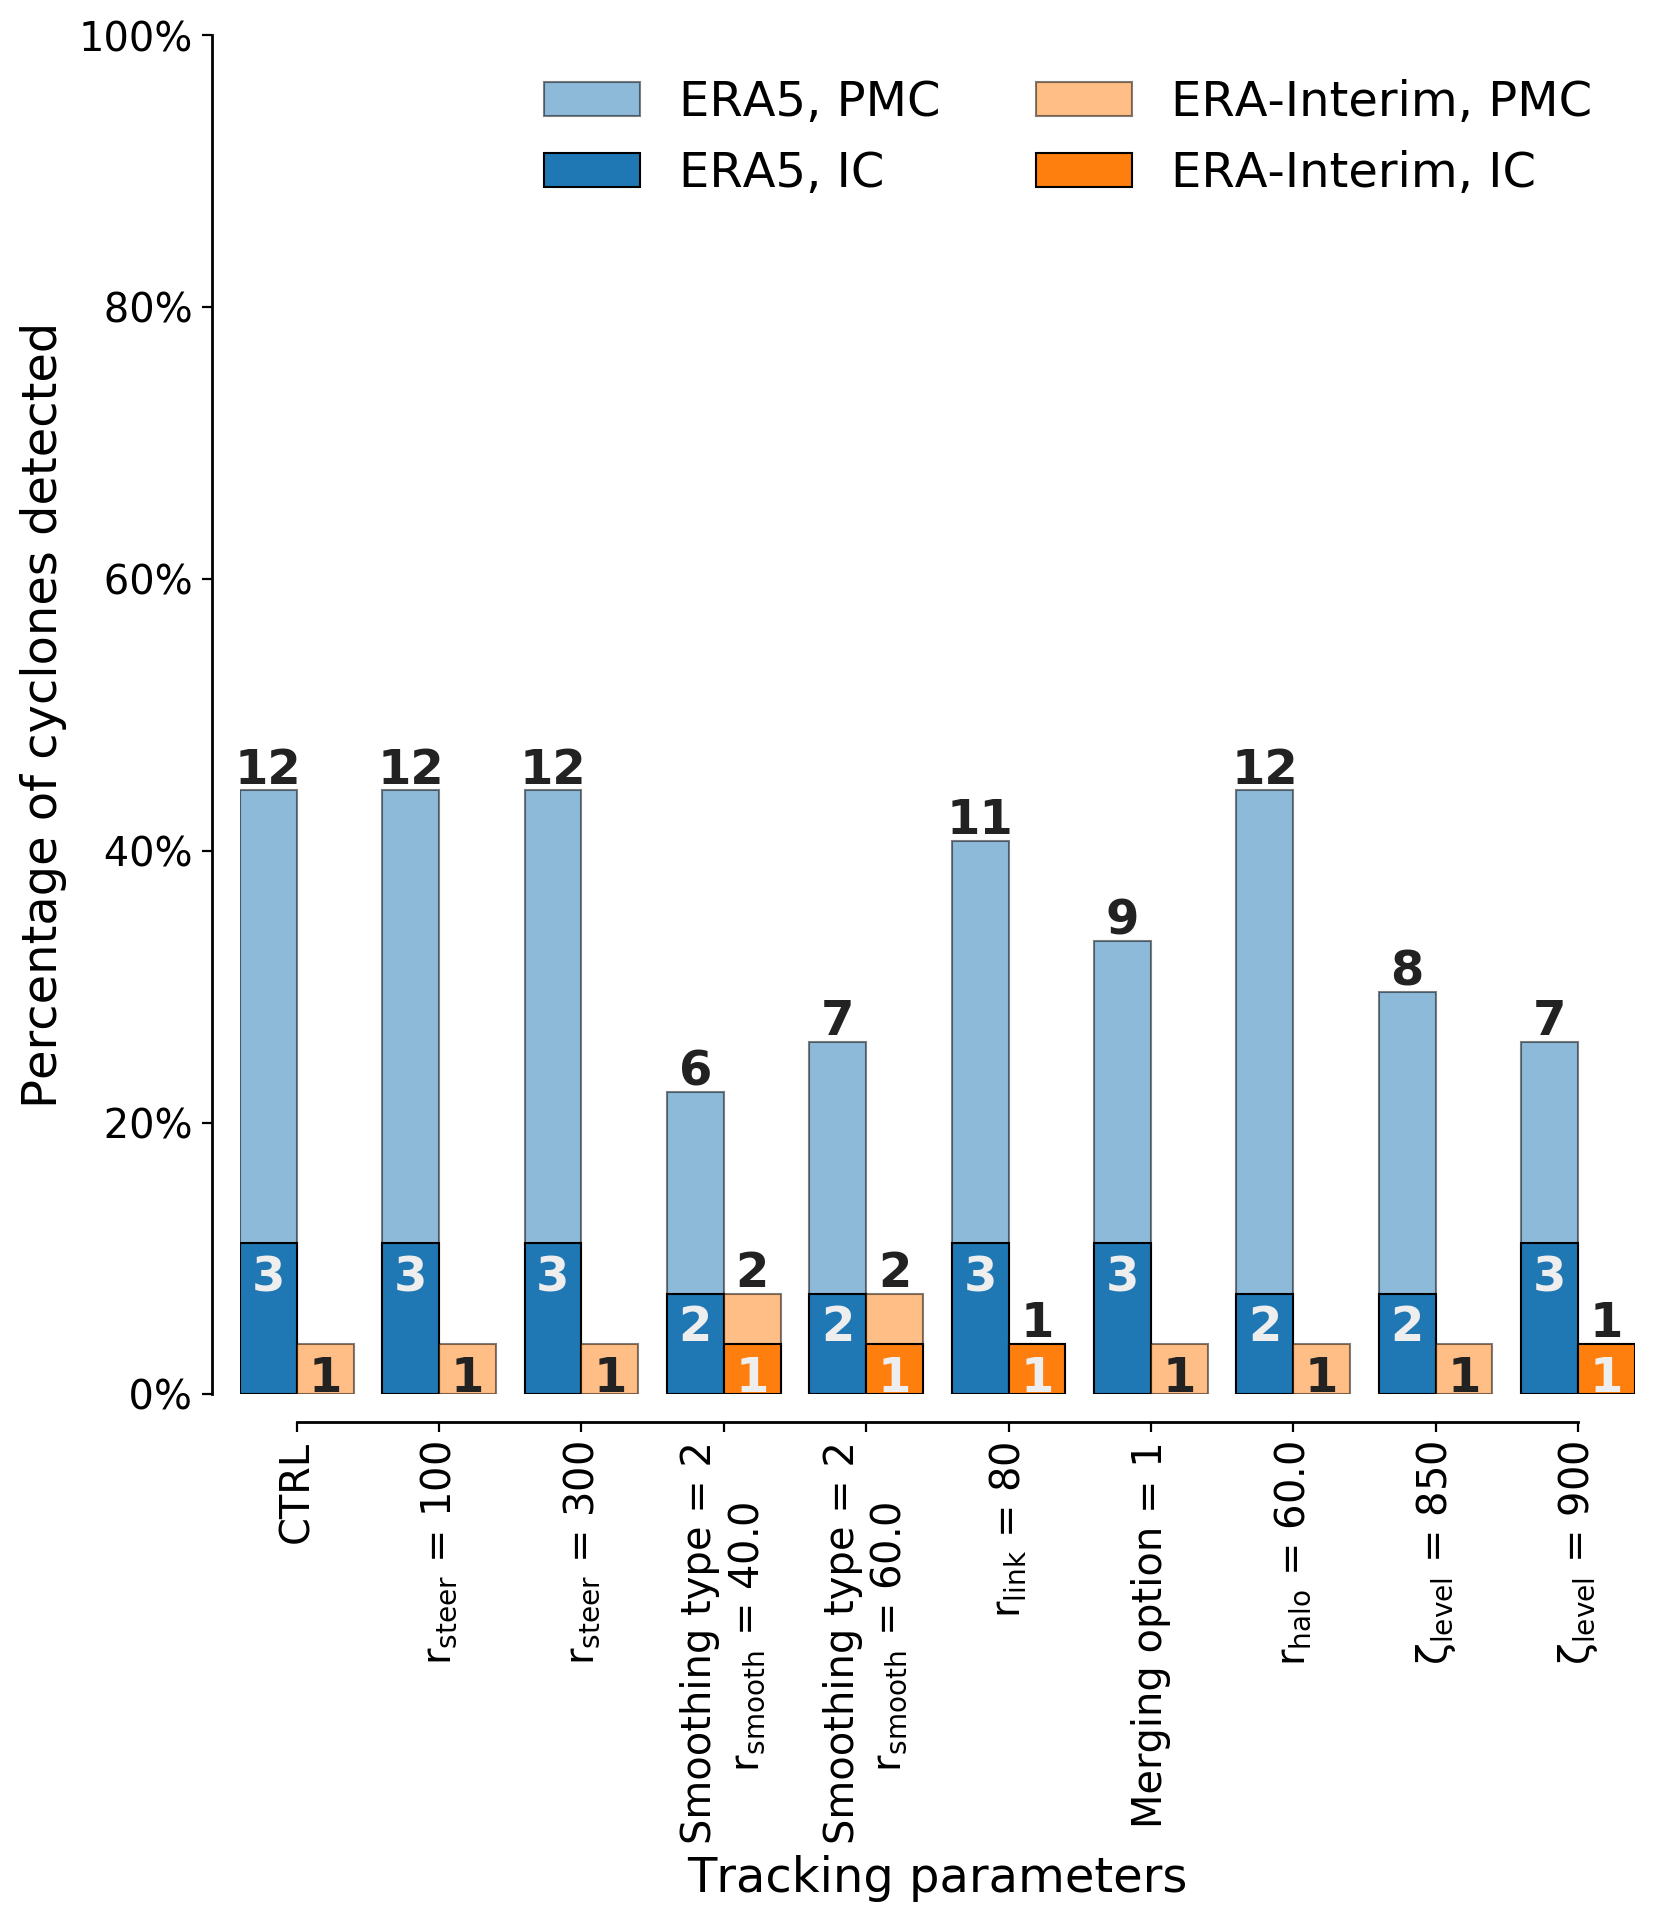

In [69]:
fig = plt.figure(figsize=(9, 9))

width = 0.4

ax = fig.add_subplot(111)
for j, (dataset, color) in enumerate(zip(datasets, cc)):
    for i, (subset) in enumerate(subsets):
        res_df = MATCH_RATES[run_group]
        ax.bar(res_df.index.values + j*width, res_df[f'{subset}_{dataset}'],
               width=width,
               **color,
               alpha= 0.5 * (i+1),
               edgecolor='#000000',
               linewidth=0.75,
               label=f'{aliases[dataset]}, {aliases[subset]}')
        
ax.legend(loc=1, ncol=2, fontsize='x-large', frameon=False)

for spine in ax.spines.values():
    if spine.spine_type in ['top', 'right']:
        spine.set_linewidth(0)
    else:
        spine.set_linewidth(1)
        spine.set_position(('axes', -0.02))
        spine.set_position(('axes', -0.02))

ax.set_xticks(res_df.index.values + width/2)
ax.set_xlim(ax.get_xticks()[0]-width, ax.get_xticks()[-1]+width)
ax.set_ylim(0, 1)
ax.set_xticklabels(xlabels, rotation=90)

ax.spines['bottom'].set_bounds(ax.get_xticks()[0], ax.get_xticks()[-1])

percent_formatter = FuncFormatter(lambda x, position: f'{x*100:3.0f}%')
ax.yaxis.set_major_formatter(percent_formatter)

ax.tick_params(labelsize='large')

# Annotate bars
fontcolor = '#222222'
for i, p in enumerate(sorted(ax.patches, key=lambda x: x.get_x())):
    if p.get_height() > 0:
        try:
            if np.allclose(p.get_x(), _p.get_x()):
                fontcolor = '#EEEEEE'
                # if abs(p.get_height() - _p.get_height()) < 0.03:
                an.set_y(_p.get_height() + 0.005)
            else:
                fontcolor = '#222222'
        except NameError:
            pass
        
        an = ax.annotate('{:d}'.format(int(p.get_height() * n_ref)),
                         (p.get_x()+0.2, p.get_height()-0.035),
                         ha='center', fontweight='bold', color=fontcolor,
                         size='x-large')
        _p = p
ax.set_xlabel(r'Tracking parameters', fontsize='x-large')
ax.set_ylabel('Percentage of cyclones detected', fontsize='x-large')
# ttl = ax.set_title(f'Number of matched vortices\nPMCTRACK vs {period}', loc='left', fontsize='xx-large');
# ax.add_artist(AnchoredText('a', loc=2, prop=dict(size='large')));
fig.savefig(mypaths.plotdir / f'vs_{period.lower()}_{run_group}_{method}')

## Verification against STARS

### Load STARS tracks

In [74]:
period = 'stars'

In [75]:
stars = read_tracks_file()

In [76]:
stars_winters = winters[:3]
stars_winters

['2008_2009', '2009_2010', '2010_2011']

In [77]:
stars_tracks = []
for winter in stars_winters:
    date_start, date_finish = winter_dates[winter]
    for i, df in stars[(stars['time'] >= date_start) & (stars['time'] <= date_finish)].groupby('N'):
        ot = OctantTrack.from_df(df)
        if ot.lifetime_h >= 6:
            stars_tracks.append(ot)
n_ref = len(stars_tracks)
n_ref

40

### All PMCTRACK runs, split into two groups

In [78]:
TRACKS = dict()
for run_group, dataset_dicts in tqdm(RUNS.items(), desc='run_group', leave=False):
    TRACKS[run_group] = dict()
    for dataset, run_dicts in tqdm(dataset_dicts.items(), desc='dataset', leave=False):
        TRACKS[run_group][dataset] = []
        for run_id, run_dict in tqdm(run_dicts, desc='run_id', leave=False):
            TR = TrackRun()
            for winter in tqdm(stars_winters, desc='winter', leave=False):
                track_res_dir = mypaths.trackresdir / dataset / f'run{run_id:03d}' / winter
                _TR = TrackRun(track_res_dir)
                _TR.categorise(lsm=lsm, **cat_kw)
                TR += _TR
            TRACKS[run_group][dataset].append(TR)
clear_output()

In [80]:
MATCH_RATES = dict()
MATCH_PAIRS = dict()
for run_group, dataset_dicts in tqdm(RUNS.items(), desc='run_group', leave=False):
    results = dict()
    MATCH_PAIRS[run_group] = dict()
    for dataset, run_dicts in tqdm(dataset_dicts.items(), desc='dataset', leave=False):
        MATCH_PAIRS[run_group][dataset] = dict()
        perf_table = np.zeros((len(run_dicts), len(subsets)), dtype=np.int64)
        for irun, (run_id, run_dict) in tqdm(enumerate(run_dicts), desc='run_id', leave=False):
            for isub, subset in tqdm(enumerate(subsets), desc='subsets', leave=False):
                match_pairs = TRACKS[run_group][dataset][irun].match_tracks(stars_tracks,
                                                                            method=method, beta=50.,
                                                                            subset=subset)
                if len(run_dict) == 0:
                    # save id of matched vortices in the ctrl run ( {} )
                    MATCH_PAIRS[run_group][dataset][subset] = match_pairs
                perf_table[irun, isub] = len(match_pairs)
        if run_group == 'vort_thresh':
            index = [r[1].get('zeta_max0', 2e-4) for r in run_dicts]
        else:
            index = range(len(run_dicts))
        results[dataset] = pd.DataFrame(data=perf_table,
                                        columns=subsets,
                                        index=index)
    res_df = pd.merge(*results.values(), how='outer', left_index=True, right_index=True, suffixes=['_'+i for i in datasets])
    res_df[res_df==0] = np.nan
    MATCH_RATES[run_group] = ((res_df / n_ref)
                              .reset_index(level=0)
                              .rename(columns=dict(index=run_group)))
clear_output()

## Vorticity thresholds

In [83]:
run_group = 'vort_thresh'

In [84]:
lcc_kw_zoom = LCC_KW.copy()
lcc_kw_zoom.update(extent=[-15, 45, 63, 82],
                   ticks=[5, 2])

0
2
4
9
10
12
14
15
20
23
24
28
30
32
33
34
36
38
39


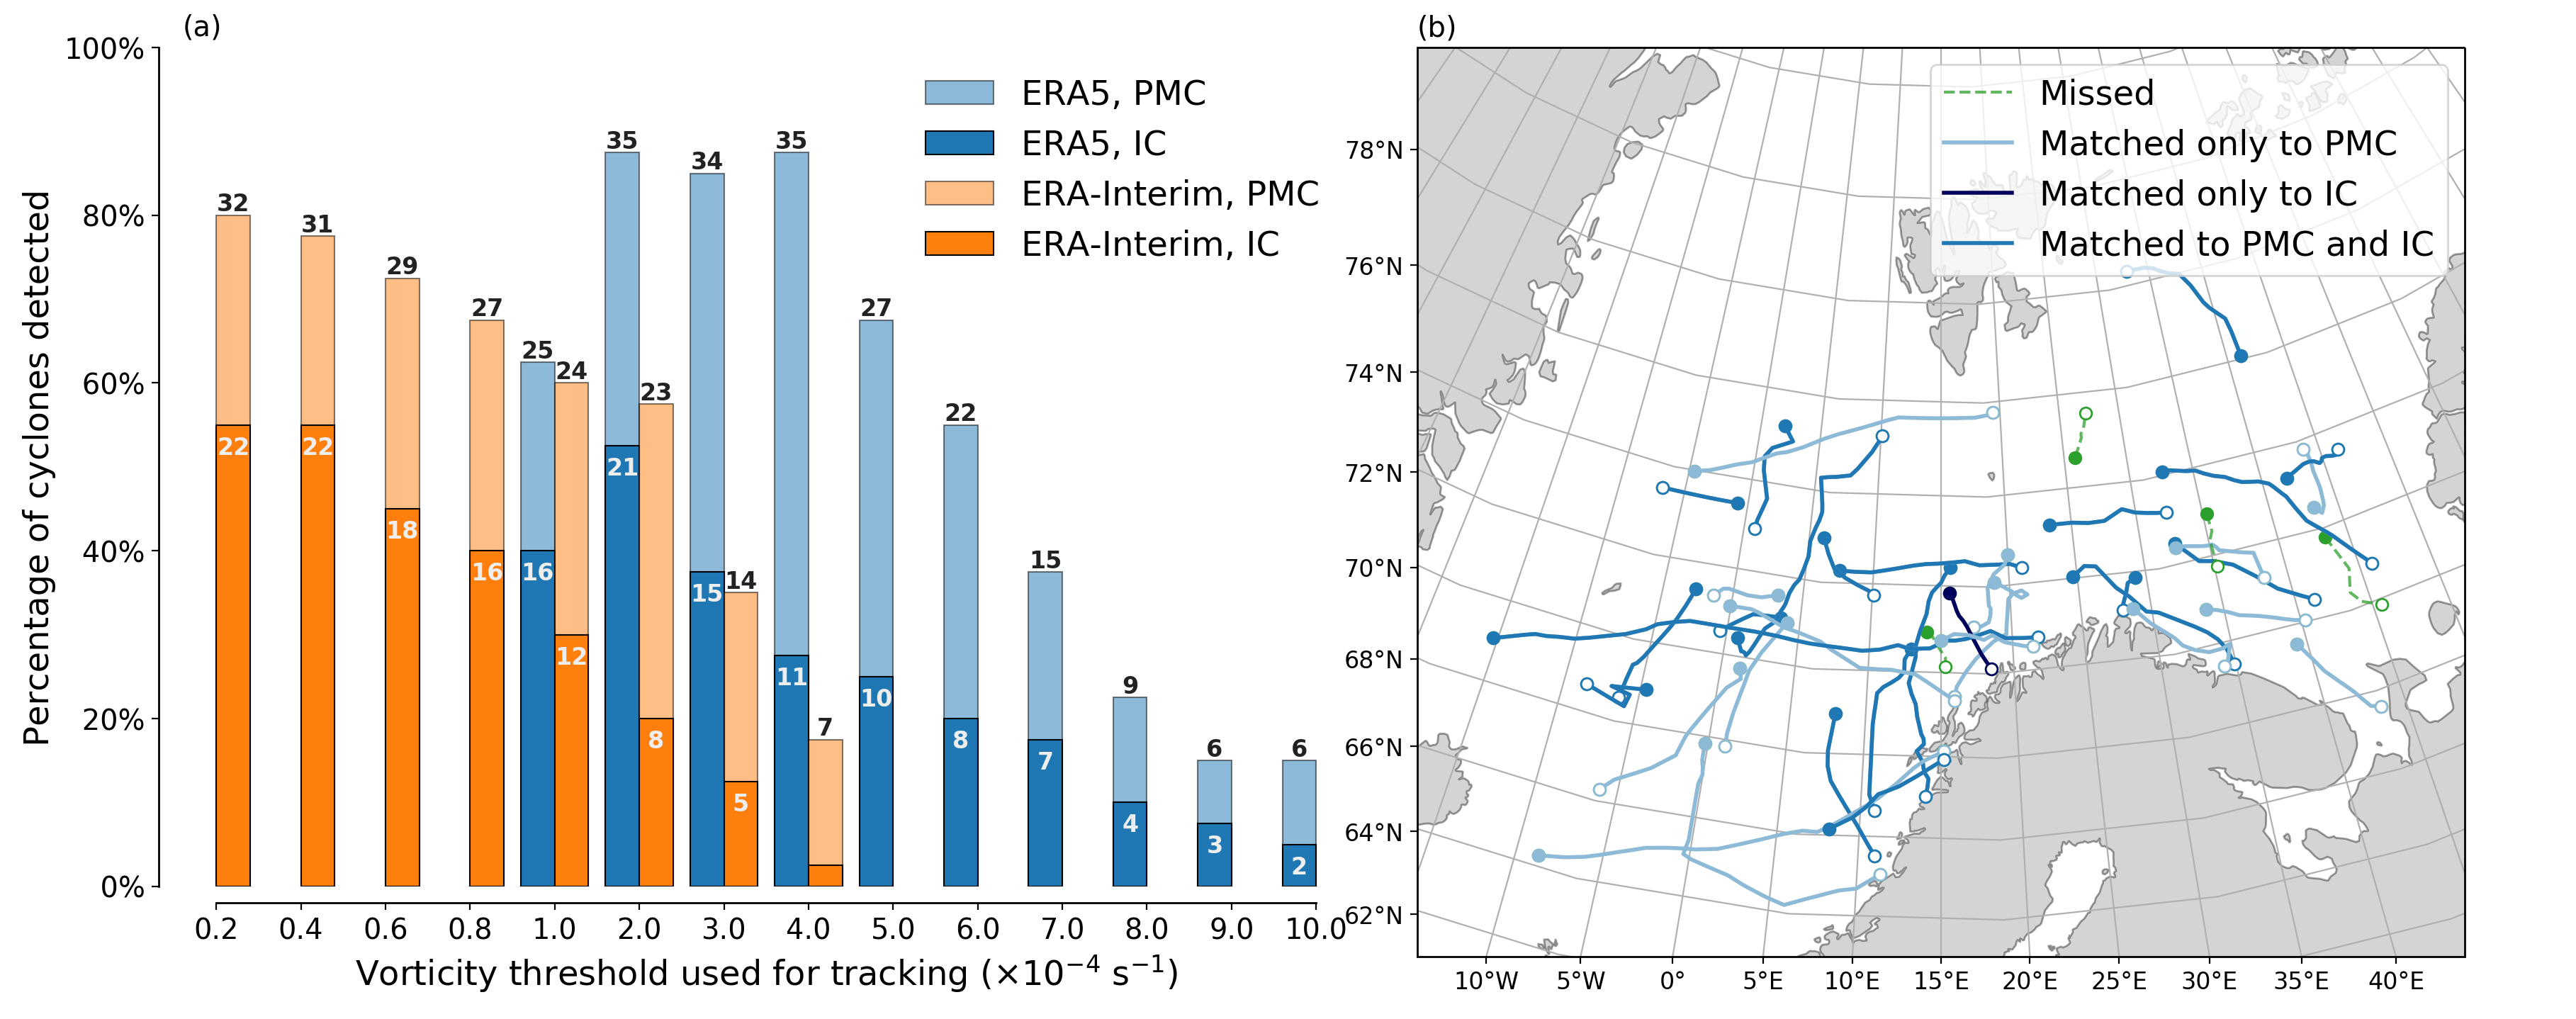

In [98]:
fig = plt.figure(figsize=(18, 7), constrained_layout=True)

width = 0.4

ax = fig.add_subplot(121)
for j, (dataset, color) in enumerate(zip(datasets, cc)):
    for i, (subset) in enumerate(subsets):
        res_df = MATCH_RATES[run_group]
        ax.bar(res_df.index.values + j*width, res_df[f'{subset}_{dataset}'],
               width=width,
               **color,
               alpha= 0.5 * (i+1),
               edgecolor='#000000',
               linewidth=0.75,
               label=f'{aliases[dataset]}, {aliases[subset]}')
        
ax.legend(loc=1, ncol=1, fontsize='x-large', frameon=False)

for spine in ax.spines.values():
    if spine.spine_type in ['top', 'right']:
        spine.set_linewidth(0)
    else:
        spine.set_linewidth(1)
        spine.set_position(('axes', -0.02))
        spine.set_position(('axes', -0.02))


ax.set_xticks(res_df.index.values + width/2)
ax.set_xticklabels((1e4 * res_df[run_group].values).round(decimals=1))
ax.set_xlim(ax.get_xticks()[0]-width, ax.get_xticks()[-1]+width)
ax.set_ylim(0, 1)

ax.spines['bottom'].set_bounds(ax.get_xticks()[0], ax.get_xticks()[-1])

percent_formatter = FuncFormatter(lambda x, position: f'{x*100:3.0f}%')
ax.yaxis.set_major_formatter(percent_formatter)

ax.tick_params(labelsize='large')

# Annotate bars
fontcolor = '#222222'
for i, p in enumerate(sorted(ax.patches, key=lambda x: x.get_x())):
    if p.get_height() > 0:
        try:
            if np.allclose(p.get_x(), _p.get_x()):
                fontcolor = '#EEEEEE'
                # if abs(p.get_height() - _p.get_height()) < 0.03:
                an.set_y(_p.get_height() + 0.005)
            else:
                fontcolor = '#222222'
        except NameError:
            pass
        
        an = ax.annotate('{:d}'.format(int(p.get_height() * n_ref)),
                         (p.get_x()+0.2, p.get_height()-0.035),
                         ha='center', fontweight='bold', color=fontcolor,
                         size='medium')
        _p = p
ax.set_xlabel(r'Vorticity threshold used for tracking ($\times10^{-4}$ $s^{-1}}$)', fontsize='x-large')
ax.set_ylabel('Percentage of cyclones detected', fontsize='x-large')
# ttl = ax.set_title(f'Number of matched vortices\nPMCTRACK vs {period}', loc='left', fontsize='xx-large');
# ax.add_artist(AnchoredText('a', loc=2, prop=dict(size='large')));
ax.set_title('(a)', loc='left', fontsize='large')

#
# Show on the map what tracks are matched in CTRL runs
#
ax = lcc_map(fig, 122, **lcc_kw_zoom)

run_group = 'vort_thresh'
dataset = 'era5'

labels = ['Missed',
          f'Matched only to {aliases[subsets[0]]}',
          f'Matched only to {aliases[subsets[1]]}',
          f'Matched to {aliases[subsets[0]]} and {aliases[subsets[1]]}']
hs = [None] * 4
for idx, df in enumerate(stars_tracks):
    df.plot_track(ax=ax, color='C2', linestyle='--', alpha=0.75, **trans)
    hs[0], = ax.plot(df.lon[0], df.lat[0], color='C2', linestyle='--', alpha=0.75, **trans)
    if idx in [i[1] for i in MATCH_PAIRS[run_group][dataset][subsets[0]]]:
        df.plot_track(ax=ax, color='#8DBAD7', linewidth=2, **trans)
        hs[1], = ax.plot(df.lon[0], df.lat[0], color='#8DBAD7', linewidth=2, **trans)
    if all([idx in [i[1] for i in MATCH_PAIRS[run_group][dataset][subset]] for subset in subsets]):
        df.plot_track(ax=ax, color='C0', linewidth=2, **trans)
        hs[3], = ax.plot(df.lon[0], df.lat[0], color='C0', linewidth=2, **trans)
    elif idx in [i[1] for i in MATCH_PAIRS[run_group][dataset][subsets[1]]]:
        df.plot_track(ax=ax, color='#00035b', linewidth=2, **trans)
        hs[2], = ax.plot(df.lon[0], df.lat[0], color='#00035b', linewidth=2, **trans)
        
hs, labels = [h for h, lab in zip(hs, labels) if h], [lab for h, lab in zip(hs, labels) if h]
    
ax.legend(hs, labels, loc=1, fontsize='x-large')
# ax.add_artist(AnchoredText('b', loc=2, prop=dict(size='large')));
ax.set_title('(b)', loc='left', fontsize='large')

fig.savefig(mypaths.plotdir / f'vs_{period.lower()}_vort_thresh_w_map_{method}')

## Other parameters

In [110]:
run_group = 'diff_params'

In [111]:
xlabels = [runs_grid_formatter(run_dict).strip()
           for i, (run_id, run_dict) in enumerate(RUNS[run_group]['era5'])]

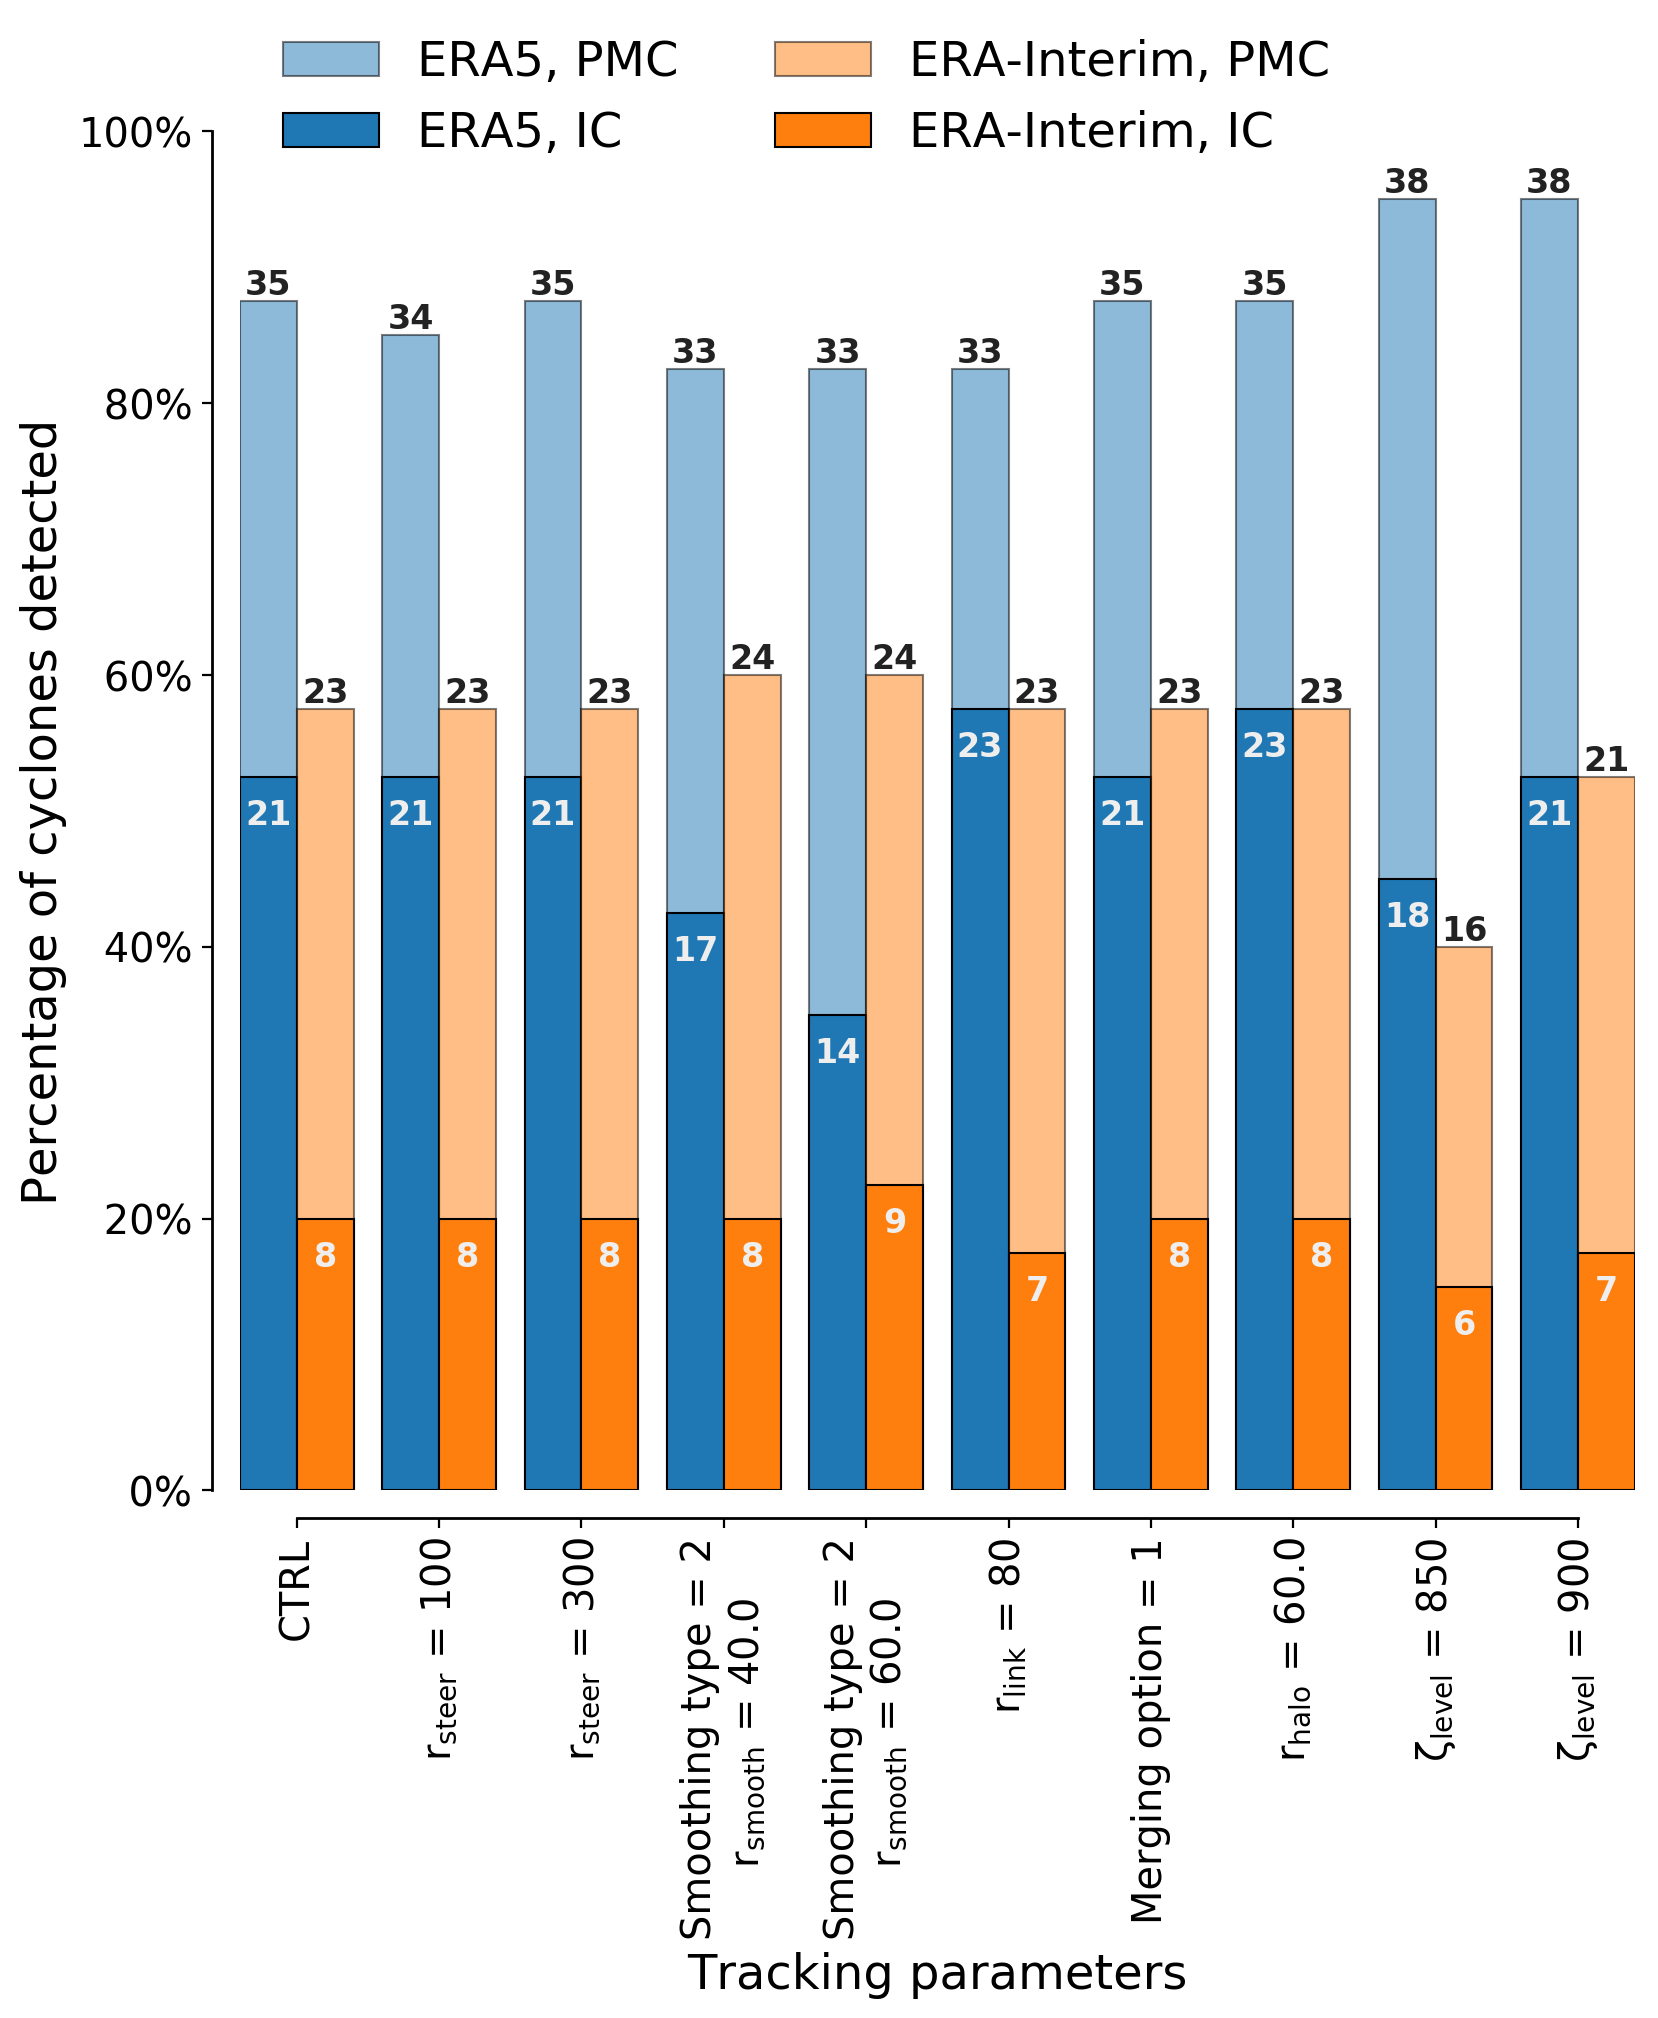

In [114]:
fig = plt.figure(figsize=(9, 9))

width = 0.4

ax = fig.add_subplot(111)
for j, (dataset, color) in enumerate(zip(datasets, cc)):
    for i, (subset) in enumerate(subsets):
        res_df = MATCH_RATES[run_group]
        ax.bar(res_df.index.values + j*width, res_df[f'{subset}_{dataset}'],
               width=width,
               **color,
               alpha= 0.5 * (i+1),
               edgecolor='#000000',
               linewidth=0.75,
               label=f'{aliases[dataset]}, {aliases[subset]}')
        
ax.legend(loc='upper left', ncol=2, fontsize='x-large', frameon=False, bbox_to_anchor=(0, 1.1))

for spine in ax.spines.values():
    if spine.spine_type in ['top', 'right']:
        spine.set_linewidth(0)
    else:
        spine.set_linewidth(1)
        spine.set_position(('axes', -0.02))
        spine.set_position(('axes', -0.02))

ax.set_xticks(res_df.index.values + width/2)
ax.set_xlim(ax.get_xticks()[0]-width, ax.get_xticks()[-1]+width)
ax.set_ylim(0, 1)
ax.set_xticklabels(xlabels, rotation=90)

ax.spines['bottom'].set_bounds(ax.get_xticks()[0], ax.get_xticks()[-1])

percent_formatter = FuncFormatter(lambda x, position: f'{x*100:3.0f}%')
ax.yaxis.set_major_formatter(percent_formatter)

ax.tick_params(labelsize='large')

# Annotate bars
fontcolor = '#222222'
for i, p in enumerate(sorted(ax.patches, key=lambda x: x.get_x())):
    if p.get_height() > 0:
        try:
            if np.allclose(p.get_x(), _p.get_x()):
                fontcolor = '#EEEEEE'
                # if abs(p.get_height() - _p.get_height()) < 0.03:
                an.set_y(_p.get_height() + 0.005)
            else:
                fontcolor = '#222222'
        except NameError:
            pass
        
        an = ax.annotate('{:d}'.format(int(p.get_height() * n_ref)),
                         (p.get_x()+0.2, p.get_height()-0.035),
                         ha='center', fontweight='bold', color=fontcolor,
                         size='medium')
        _p = p
ax.set_xlabel(r'Tracking parameters', fontsize='x-large')
ax.set_ylabel('Percentage of cyclones detected', fontsize='x-large')
# ttl = ax.set_title(f'Number of matched vortices\nPMCTRACK vs {period}', loc='left', fontsize='xx-large');
# ax.add_artist(AnchoredText('a', loc=2, prop=dict(size='large')));
fig.savefig(mypaths.plotdir / f'vs_{period.lower()}_{run_group}_{method}')